In [27]:
import tensorflow as tf
import pandas as pd
import math
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt

SHUFFLE_BUFFER = 500
BATCH_SIZE = 36
EPOCHS = 50

In [28]:
data = pd.read_csv('data/prepared_data.csv')

TRAINING_SIZE = math.floor(0.5*len(data))
TEST_SIZE = math.floor(0.3*len(data))
EVALUATION_SIZE = math.floor(0.2*len(data))

indices = (TRAINING_SIZE, TRAINING_SIZE+TEST_SIZE, TRAINING_SIZE+TEST_SIZE+EVALUATION_SIZE)
inputs = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']
outputs = ['class_GALAXY','class_QSO','class_STAR']

training = data[0:indices[0]]
test = data[indices[0]:indices[1]]
evaluation = data[indices[1]:indices[2]]
def update_professor():
	return {
		"training": {
			"questions": training[inputs],
			"answers": training[outputs]
		},
		"test": {
			"questions": test[inputs],
			"answers": test[outputs]
		},
		"evaluation": {
			"questions": evaluation[inputs],
			"answers": evaluation[outputs]
		}
	}
professor = update_professor()

# Curriculum Learning Method

# Inception Network

This is the network trained on the entire dataset

In [29]:
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(data[['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'redshift']])

inception_model = keras.models.load_model(filepath='neural-network.tf')

inception_model.compile(
	optimizer='sgd',
	loss=keras.losses.BinaryCrossentropy(),
	metrics=['accuracy']
)

history = model.fit(professor['training']['questions'], professor['training']['answers'], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3812 - accuracy: 0.9592 - val_loss: 0.3840 - val_accuracy: 0.9577
Epoch 2/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3799 - accuracy: 0.9586 - val_loss: 0.3831 - val_accuracy: 0.9573
Epoch 3/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3793 - accuracy: 0.9580 - val_loss: 0.3827 - val_accuracy: 0.9580
Epoch 4/50
139/139 [==============================] - 0s 1ms/step - loss: 0.3789 - accuracy: 0.9588 - val_loss: 0.3822 - val_accuracy: 0.9583
Epoch 5/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3784 - accuracy: 0.9592 - val_loss: 0.3820 - val_accuracy: 0.9580
Epoch 6/50
139/139 [==============================] - 0s 3ms/step - loss: 0.3781 - accuracy: 0.9592 - val_loss: 0.3812 - val_accuracy: 0.9590
Epoch 7/50
139/139 [==============================] - 0s 2ms/step - loss: 0.3777 - accuracy: 0.9606 - val_loss: 0.3806 - val_accuracy: 0.9597
Epoch 

# Physically Verify that Model is Correct

In [30]:
inception_model.evaluate(professor["evaluation"]["questions"], professor['evaluation']['answers'])

63/63 [==============================] - 0s 677us/step - loss: 0.3829 - accuracy: 0.9550


[0.38290801644325256, 0.9549999833106995]

In [31]:
sample = evaluation.sample(5)
print(sample[outputs])
model.__call__(sample[inputs])

      class_GALAXY  class_QSO  class_STAR
8897           0.1        0.1         0.9
9323           0.1        0.1         0.9
9285           0.1        0.1         0.9
9565           0.9        0.1         0.1
8484           0.9        0.1         0.1


<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.19339424, 0.09183413, 0.8233962 ],
       [0.18854368, 0.10082877, 0.82143444],
       [0.08951795, 0.094596  , 0.90112174],
       [0.84897244, 0.13996342, 0.13722265],
       [0.83046305, 0.15576261, 0.12319732]], dtype=float32)>

Text(0.5, 1.0, 'Graph to show Training vs Validation Accuracy')

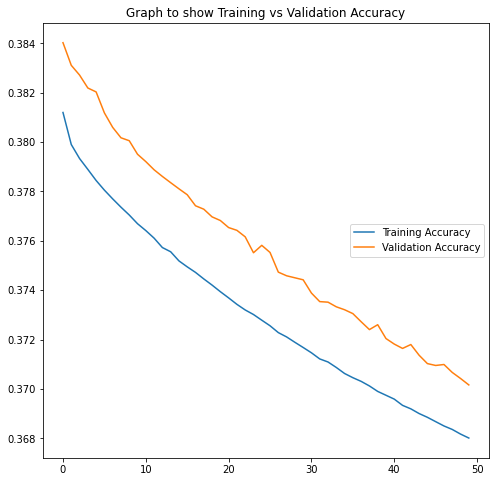

In [32]:
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["loss"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_loss"], label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Graph to show Training vs Validation Accuracy')

Text(0.5, 1.0, 'Graph to show Training vs Validation Loss')

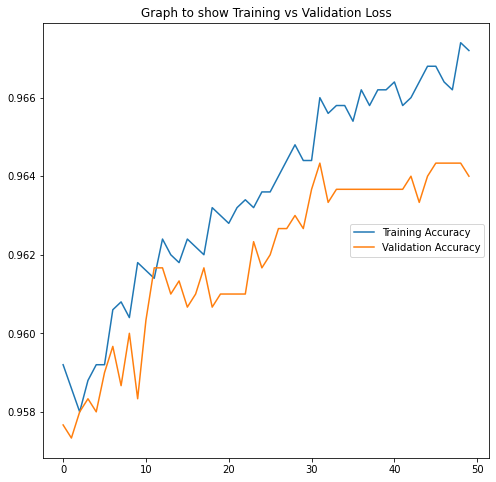

In [33]:
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Graph to show Training vs Validation Loss')

# Curriculum Learning Method

### Score Data -  Self-taught Scoring Function

In [34]:
# curriculum_learning_method(g, f, X:pd.DataFrame):
from sys import stdout
print('[clm]: scoring Xi')
preds = inception_model.predict(training[inputs])
def calc_score(x, output):
	x = list(x)
	output = list(output)
	correct = x.index(max(x)) == output.index(max(output))
	# print({"X": x, "output":output, "corr":correct})
	return max(x) + 1 if correct else -1

score = pd.Series([calc_score(x, training.loc[i, outputs]) for i, x in enumerate(preds)])
temp = pd.DataFrame({**{x:training[x] for x in training}, "score": score, "preds": list(preds) })
temp.head()

[clm]: scoring Xi


,Unnamed: 0,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR,score,preds
0,0,0.167450,-0.584893,1.031435,-0.348542,-0.837238,-0.946010,-0.995292,-0.369713,0.1,0.1,0.9,1.662355,"[0.31678396, 0.048391193, 0.66235536]"
1,1,0.168853,-0.583085,0.052428,-0.166524,-0.154148,-0.082640,-0.026042,-0.369831,0.1,0.1,0.9,1.851537,"[0.15416527, 0.079752445, 0.8515365]"
2,2,0.170566,-0.583446,0.921522,0.867050,0.593124,0.441179,0.314512,-0.053024,0.9,0.1,0.1,1.868666,"[0.86866635, 0.15068138, 0.099635154]"
3,3,0.174549,-0.586471,-1.030579,-0.813587,-0.636660,-0.526578,-0.430900,-0.369974,0.1,0.1,0.9,1.809664,"[0.2047337, 0.09967512, 0.80966437]"
4,4,0.174816,-0.584383,-1.290168,-1.172461,-0.376744,-0.025100,0.158269,-0.368171,0.1,0.1,0.9,1.986968,"[0.0156641, 0.0858981, 0.98696816]"


### Sort Data by score

In [35]:
print("[clm]: sorting dataframe according to score")
temp = temp.sort_values(by=["score"], ascending=False)

[clm]: sorting dataframe according to score


### Batch Data - Fixed Exponential Pacing Function

In [56]:
STARTING_PERCENT = 0.4
INCREASING_DATA_SIZE = 0.1
STEP_LENGTH = 5

def g_fixed_exponential(i, N):
	return math.floor(min(STARTING_PERCENT*pow(INCREASING_DATA_SIZE,i/STEP_LENGTH), 1)*N)

Bm = []
index = 0
size = 0
fl = False
print('[clm]: creating mini-batches')
for i in range(1, len(temp)):
	if fl:
		break
	index = size
	size += g_fixed_exponential(i, 5000)
	if size > len(temp):
		fl = True
	size = size if size <= len(temp) else len(temp)
	Bm.append(temp[index:size].sample(frac=1))

print(f'[clm]: done, len(Bm) = {len(Bm)}')

[clm]: creating mini-batches
[clm]: done, len(Bm) = 10


In [57]:
l = [len(x) for x in Bm]
print(l)
print(sum(l))
Bm[0]

[1449, 1050, 761, 551, 400, 289, 210, 152, 110, 28]
5000


,Unnamed: 0,ra,dec,u,g,r,i,z,redshift,class_GALAXY,class_QSO,class_STAR,score,preds
3225,3225,0.464541,-0.585914,0.611441,-0.243471,-0.638683,-0.748831,-0.898607,-0.120802,0.9,0.1,0.1,1.911110,"[0.9111098, 0.09222019, 0.08284673]"
4212,4212,-0.437844,-0.563235,1.102176,0.845579,0.565356,0.400052,0.306300,-0.172664,0.9,0.1,0.1,1.886164,"[0.88616395, 0.11371258, 0.1052036]"
2619,2619,0.400204,-0.586341,0.384025,0.231632,0.007049,-0.171158,-0.279294,-0.155810,0.9,0.1,0.1,1.889457,"[0.88945687, 0.117372364, 0.100417644]"
1309,1309,0.846027,-0.614067,1.131114,2.254844,2.192072,2.205404,2.308282,2.941972,0.1,0.9,0.1,1.898933,"[0.09229055, 0.8989326, 0.10553956]"
1629,1629,-3.108654,-0.060990,1.066504,2.082060,2.438765,2.392634,2.484846,3.639783,0.1,0.9,0.1,1.932618,"[0.040640414, 0.93261814, 0.12075883]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4412,4412,-0.357077,-0.572481,0.906027,-0.067493,-0.487470,-0.639610,-0.802670,-0.183596,0.9,0.1,0.1,1.890367,"[0.890367, 0.08212456, 0.101240814]"
2933,2933,-0.256243,-0.595137,0.878464,0.554852,0.207749,0.035926,-0.068870,-0.019808,0.9,0.1,0.1,1.897359,"[0.8973588, 0.108932495, 0.09393448]"
1473,1473,-0.512132,-0.578025,0.787160,0.369481,0.039537,-0.170160,-0.325405,-0.196886,0.9,0.1,0.1,1.914133,"[0.9141327, 0.08974758, 0.08237779]"
3377,3377,-0.091731,-0.719890,0.619913,0.321737,0.137499,0.018874,-0.071197,-0.195741,0.9,0.1,0.1,1.890437,"[0.8904375, 0.10893834, 0.10558534]"


In [72]:
model = keras.models.load_model(filepath="neural-network.tf")
model.compile(
	optimizer='sgd',
	loss=keras.losses.BinaryCrossentropy(),
	metrics=['accuracy']
)

book = []
bio = {
	"accuracy": [],
	"val_accuracy": []
}
from sys import stdout

aggregator = pd.DataFrame({x:[] for x in training})

runs = math.floor(EPOCHS/STEP_LENGTH)

size = 0

STARTING_PERCENT = 0.5
INCREASING_DATA_SIZE = 0.2
STEP_LENGTH = 10

while not len(training) - len(aggregator) < 500:
	index = size
	size += g_fixed_exponential(i, len(training)-size)
	if size > len(training):
		fl = True
	size = size if size <= len(training) else len(training)
	aggregator = aggregator.append(training[index:size].sample(frac=1))
	print(f"==== B{i} = {len(aggregator)} ===")
	h = model.fit(aggregator[inputs], aggregator[outputs], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=STEP_LENGTH, batch_size=BATCH_SIZE)
	book.append(h)
	bio["accuracy"].extend(h.history['accuracy'])
	bio["val_accuracy"].extend(h.history['val_accuracy'])

==== B9 = 587 ===
Epoch 1/10
17/17 [==============================] - 1s 13ms/step - loss: 0.3720 - accuracy: 0.9591 - val_loss: 0.3852 - val_accuracy: 0.9557
Epoch 2/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3715 - accuracy: 0.9557 - val_loss: 0.3858 - val_accuracy: 0.9543
Epoch 3/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3712 - accuracy: 0.9557 - val_loss: 0.3857 - val_accuracy: 0.9547
Epoch 4/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3710 - accuracy: 0.9557 - val_loss: 0.3859 - val_accuracy: 0.9540
Epoch 5/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3709 - accuracy: 0.9574 - val_loss: 0.3857 - val_accuracy: 0.9530
Epoch 6/10
17/17 [==============================] - 0s 6ms/step - loss: 0.3709 - accuracy: 0.9574 - val_loss: 0.3860 - val_accuracy: 0.9527
Epoch 7/10
17/17 [==============================] - 0s 5ms/step - loss: 0.3708 - accuracy: 0.9591 - val_loss: 0.3856 - val_accuracy: 0.9523
E

In [73]:
def plotter(history):
	epochs_range = range(STEP_LENGTH)
	plt.figure(figsize=(8, 8))
	plt.plot(epochs_range, history.history["accuracy"], label='Training Accuracy')
	plt.plot(epochs_range, history.history["val_accuracy"], label='Validation Accuracy')
	plt.legend(loc='center right')
	plt.title('Graph to show Training vs Validation Accuracy')

In [74]:
model.evaluate(professor["evaluation"]["questions"], professor['evaluation']['answers'])

63/63 [==============================] - 0s 937us/step - loss: 0.3613 - accuracy: 0.9735


[0.36132195591926575, 0.9735000133514404]

Text(0.5, 1.0, 'Graph to show Training vs Validation Accuracy')

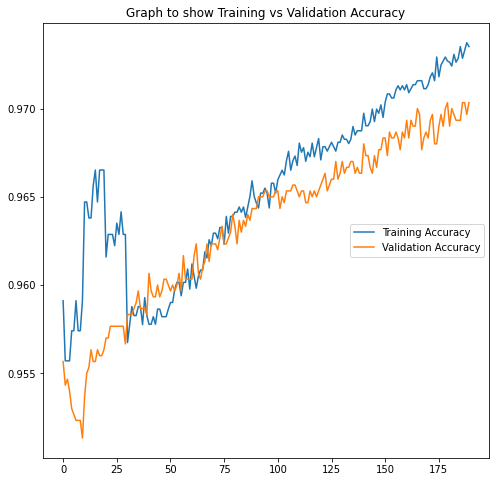

In [75]:
{x:len(bio[x]) for x in bio}

epochs_range = range(len(bio['accuracy']))
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, bio["accuracy"], label='Training Accuracy')
plt.plot(epochs_range, bio["val_accuracy"], label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Graph to show Training vs Validation Accuracy')

In [ ]:
# histories = {}
# bio = {"accuracy":[], "val_accuracy": []}


# buckets = math.floor(EPOCHS/STEP_LENGTH)
# total_data = len(training)
# initial_data_count = math.floor(STARTING_PERCENT*total_data)
# curr_percentage = 1
# for i in range(0, buckets):
#     curr_percentage = (i+1)/buckets
#     # curr_percentage = min(curr_percentage*1.9, 1)
#     data_left = total_data-initial_data_count
#     offset_data_count = math.floor(curr_percentage*data_left)

#     upper_bound = initial_data_count + offset_data_count
#     data = training.loc[0: upper_bound]
#     history = model.fit(data[inputs], data[outputs], validation_data=(professor['test']['questions'], professor['test']['answers']), epochs=STEP_LENGTH, batch_size=BATCH_SIZE)

#     bio["accuracy"].extend(history.history['accuracy'])
#     bio["val_accuracy"].extend(history.history['val_accuracy'])

# {x:len(bio[x]) for x in bio}

# epochs_range = range(len(bio['accuracy']))
# plt.figure()
# plt.plot(epochs_range, bio["accuracy"], label='Training Accuracy')
# plt.plot(epochs_range, bio["val_accuracy"], label='Validation Accuracy')
# plt.legend(loc='center right')
# plt.title('Graph to show Training vs Validation Accuracy')